In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
from custom_qiskit_v3_3.datageneration import Sklearn_DataLoader, DataScaler
from custom_qiskit_v3_3.classifier import Kernel, BinarySVM
import numpy as np 
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm

kernel = Kernel('linear', 1)
repeat = 100
Cs = np.logspace(-8, 8, 100)
options = ['SVM', 'REDUCED_SVM', 'QASVM', 'REDUCED_QASVM']
svm_s = np.empty((len(options), len(Cs), repeat))

dl = Sklearn_DataLoader('iris', labels=(1,2))
ds = DataScaler('standard')
svm_dict = {}

for i, C in enumerate(tqdm(Cs)):
    svm_dict[C] = {}
    for j, mut in enumerate(options):
        svm_dict[C][mut] = []
        for k in range(repeat):
            svm = BinarySVM(kernel, C, mut)
            X, y, Xt, yt = dl(2**6, 0)
            svm.fit(ds(X), y)
            svm_s[j, i, k] = 1-svm.accuracy(ds.transform(Xt), yt) if svm.status=='optimal' else None
            svm_dict[C][mut].append(svm)
svm_means = svm_s.mean(axis=2)
svm_stds = svm_s.std(axis=2)

  0%|          | 0/100 [00:00<?, ?it/s]

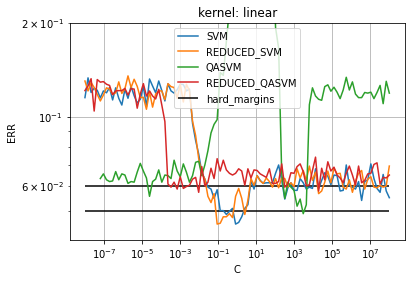

In [25]:
plt.figure()
#[plt.errorbar(Cs, svm_means[i], yerr=svm_stds[i], label = options[i]) for i in range(len(options))]
[plt.plot(Cs, svm_means[i], label = options[i]) for i in range(len(options))]
svms = [BinarySVM(kernel, None, mut) for mut in options]
X, y, _, _ = dl(100, 0)
[svm.fit(X, y) for svm in svms]
hard_margins = np.array([1-svm.accuracy(X, y) if svm.status=='optimal' else np.inf for svm in svms])
plt.hlines(hard_margins, min(Cs), max(Cs), label='hard_margins')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('ERR')
plt.ylim([0, .2])
plt.title(f'kernel: {kernel.kind}')
plt.savefig('./figs/MyFig.png')

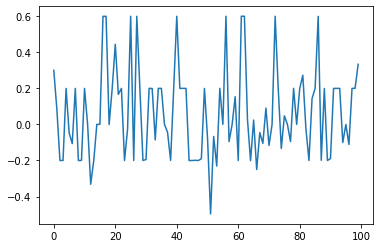

In [19]:
plt.plot([svm.b for svm in svm_dict[Cs[56]]['QASVM']])

In [22]:
import dill
with open('svms.dill', 'wb') as f:
    dill.dump(svm_dict, f)